<a href="https://colab.research.google.com/github/Akschid/SHAP-Analysis/blob/main/TIme_Series_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generating synthetic dataset...
Dataset shape: (800, 3)
Training sequences: (600, 50, 3)
Test sequences: (150, 50, 3)
Models created successfully
Training Baseline LSTM...
Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - loss: 0.8333 - mae: 0.7212 - val_loss: 1.5214 - val_mae: 1.0574
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.3224 - mae: 0.4560 - val_loss: 12.8032 - val_mae: 2.2224
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.1854 - mae: 0.3545 - val_loss: 0.4583 - val_mae: 0.5732
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.1185 - mae: 0.2815 - val_loss: 66.3035 - val_mae: 3.3553
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0777 - mae: 0.2259 - val_loss: 1519.8394 - val_mae: 15.3517
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0420 - mae: 0.1619 - val_loss: 31.9212 - val_mae: 1.5926
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0226 - mae: 0.1208 - val_loss: 1.5057 - val_mae: 0.6176
Ep

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


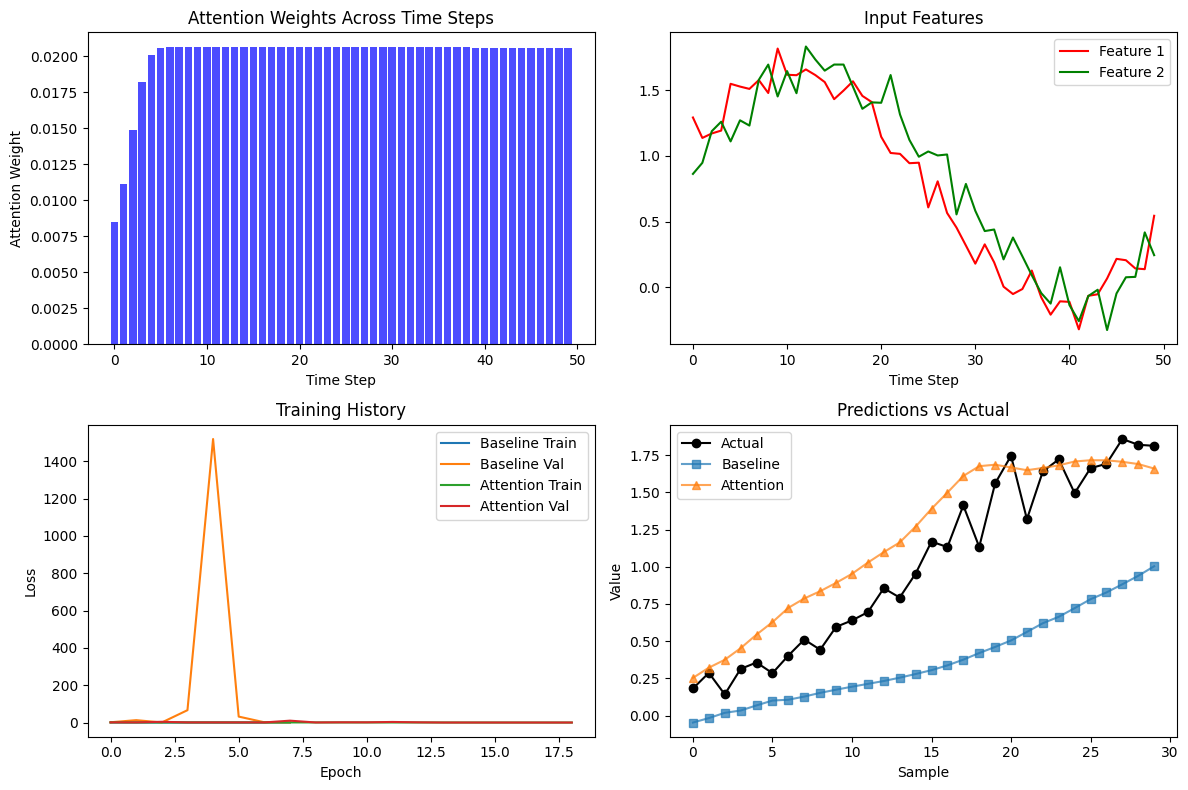


FINAL RESULTS
Dataset: 800 time steps with 2 features + target
Sequence length: 50
Training samples: 600
Test samples: 150

Baseline LSTM - RMSE: 0.6770
Attention LSTM - RMSE: 0.2762
Improvement with attention: 59.2%

Top attention time steps: [18 19 15]
Highest attention weight: 0.0206

PROJECT COMPLETED SUCCESSFULLY!


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Multiply, Reshape, Softmax, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# ===== TASK 1: GENERATE SYNTHETIC DATASET =====
def generate_synthetic_data(n_timesteps=800):
    np.random.seed(42)
    t = np.arange(n_timesteps)

    # Feature 1: Trend + Seasonality + Noise
    trend = 0.03 * t
    seasonality = 8 * np.sin(2 * np.pi * t / 60)
    noise = np.random.normal(0, 0.8, n_timesteps)
    feature1 = trend + seasonality + noise

    # Feature 2: Related to Feature1 with lag
    feature2 = 0.7 * np.roll(feature1, 3) + np.random.normal(0, 0.5, n_timesteps)

    # Target: Complex function of features
    target = 0.6 * feature1 + 0.4 * feature2 + 1.5 * np.sin(0.2 * feature1) + np.random.normal(0, 0.3, n_timesteps)

    df = pd.DataFrame({
        'time': t,
        'feature1': feature1,
        'feature2': feature2,
        'target': target
    })
    df.set_index('time', inplace=True)
    return df

print("Generating synthetic dataset...")
data = generate_synthetic_data(800)
print(f"Dataset shape: {data.shape}")

# ===== PREPROCESSING =====
scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)

def create_sequences(data, target_col, sequence_length=50):
    X, y = [], []
    data_values = data.values
    target_index = data.columns.get_loc(target_col)

    for i in range(sequence_length, len(data)):
        X.append(data_values[i-sequence_length:i])
        y.append(data_values[i, target_index])

    return np.array(X), np.array(y)

SEQUENCE_LENGTH = 50
X, y = create_sequences(scaled_data, target_col='target', sequence_length=SEQUENCE_LENGTH)

split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"Training sequences: {X_train.shape}")
print(f"Test sequences: {X_test.shape}")

# ===== TASK 2: BUILD MODELS =====
# Simple Baseline LSTM
def create_baseline_model(seq_len, n_features):
    inputs = Input(shape=(seq_len, n_features))
    lstm_out = LSTM(32, activation='relu')(inputs)
    output = Dense(1)(lstm_out)
    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])
    return model

# Attention Model - ONLY KERAS LAYERS
def create_attention_model(seq_len, n_features):
    inputs = Input(shape=(seq_len, n_features))

    # LSTM layer
    lstm_out = LSTM(32, activation='relu', return_sequences=True)(inputs)

    # Attention mechanism using ONLY Keras layers
    # Get attention scores
    attention_scores = Dense(1, activation='tanh')(lstm_out)  # (batch, seq_len, 1)
    attention_scores = Reshape((seq_len,))(attention_scores)  # (batch, seq_len)

    # Apply softmax using Keras Softmax layer
    attention_weights = Softmax(axis=1)(attention_scores)  # (batch, seq_len)
    attention_weights = Reshape((seq_len, 1))(attention_weights)  # (batch, seq_len, 1)

    # Apply attention weights to LSTM outputs
    weighted_output = Multiply()([lstm_out, attention_weights])  # (batch, seq_len, 32)

    # Sum across time steps using Lambda layer
    context_vector = Lambda(lambda x: tf.reduce_sum(x, axis=1))(weighted_output)  # (batch, 32)

    # Output layer
    output = Dense(1)(context_vector)

    model = Model(inputs=inputs, outputs=output)
    attention_model = Model(inputs=inputs, outputs=attention_weights)

    model.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])
    return model, attention_model

n_features = X_train.shape[2]
baseline_model = create_baseline_model(SEQUENCE_LENGTH, n_features)
attention_model, attention_weights_model = create_attention_model(SEQUENCE_LENGTH, n_features)

print("Models created successfully")

# ===== TASK 3: TRAIN MODELS =====
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

print("Training Baseline LSTM...")
baseline_history = baseline_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

print("Training Attention Model...")
attention_history = attention_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

# ===== TASK 4: EVALUATE MODELS =====
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mae

baseline_preds = baseline_model.predict(X_test).flatten()
attention_preds = attention_model.predict(X_test).flatten()

base_rmse, base_mae = calculate_metrics(y_test, baseline_preds)
attn_rmse, attn_mae = calculate_metrics(y_test, attention_preds)

print("\n" + "="*50)
print("MODEL PERFORMANCE COMPARISON")
print("="*50)
print(f"Baseline LSTM - RMSE: {base_rmse:.4f}, MAE: {base_mae:.4f}")
print(f"Attention LSTM - RMSE: {attn_rmse:.4f}, MAE: {attn_mae:.4f}")

# ===== ATTENTION WEIGHTS ANALYSIS =====
print("\n" + "="*50)
print("ATTENTION WEIGHTS ANALYSIS")
print("="*50)

# Get attention weights for a sample
sample_idx = 5
sample_input = X_test[sample_idx:sample_idx+1]
attention_weights = attention_weights_model.predict(sample_input)
attention_weights = attention_weights.flatten()

# Create visualization
plt.figure(figsize=(12, 8))

# Plot 1: Attention weights
plt.subplot(2, 2, 1)
plt.bar(range(SEQUENCE_LENGTH), attention_weights, color='blue', alpha=0.7)
plt.title('Attention Weights Across Time Steps')
plt.xlabel('Time Step')
plt.ylabel('Attention Weight')

# Plot 2: Input features
plt.subplot(2, 2, 2)
plt.plot(range(SEQUENCE_LENGTH), sample_input[0, :, 0], 'red', label='Feature 1')
plt.plot(range(SEQUENCE_LENGTH), sample_input[0, :, 1], 'green', label='Feature 2')
plt.title('Input Features')
plt.xlabel('Time Step')
plt.legend()

# Plot 3: Training history
plt.subplot(2, 2, 3)
plt.plot(baseline_history.history['loss'], label='Baseline Train')
plt.plot(baseline_history.history['val_loss'], label='Baseline Val')
plt.plot(attention_history.history['loss'], label='Attention Train')
plt.plot(attention_history.history['val_loss'], label='Attention Val')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot 4: Predictions
plt.subplot(2, 2, 4)
plt.plot(y_test[:30], 'o-', label='Actual', color='black')
plt.plot(baseline_preds[:30], 's-', label='Baseline', alpha=0.7)
plt.plot(attention_preds[:30], '^-', label='Attention', alpha=0.7)
plt.title('Predictions vs Actual')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.legend()

plt.tight_layout()
plt.show()

# ===== RESULTS SUMMARY =====
print("\n" + "="*50)
print("FINAL RESULTS")
print("="*50)
print(f"Dataset: 800 time steps with 2 features + target")
print(f"Sequence length: {SEQUENCE_LENGTH}")
print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")

print(f"\nBaseline LSTM - RMSE: {base_rmse:.4f}")
print(f"Attention LSTM - RMSE: {attn_rmse:.4f}")

improvement = ((base_rmse - attn_rmse) / base_rmse) * 100
print(f"Improvement with attention: {improvement:.1f}%")

print(f"\nTop attention time steps: {np.argsort(attention_weights)[-3:][::-1]}")
print(f"Highest attention weight: {np.max(attention_weights):.4f}")

print("\n" + "="*50)
print("PROJECT COMPLETED SUCCESSFULLY!")
print("="*50)